# Tutorial 8: Machine Learning with `SQuADDS`

In this tutorial, we will walk you through how to use SQuADDS to create ML interpolation solutions.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

## Collecting Training Data from `SQuADDS`

For this tutorial, we will be trying to predict the design space variables of a qubit-cavity system.

In [3]:
from squadds import SQuADDS_DB, Analyzer
import pandas as pd

In [4]:
db = SQuADDS_DB()
db.select_system(["qubit","cavity_claw"])
db.select_qubit("TransmonCross")
db.select_cavity_claw("RouteMeander")
db.select_resonator_type("quarter")
merged_df = db.create_system_df()
analyzer = Analyzer(db)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Recall that we need all Hamiltonian parameters to generate a **complete** training dataset. For this tutorial, I have chosen some demo targets to generate the training data. 

In [5]:
seed_data_df = pd.read_csv('data/seed_data.csv')
seed_data_df

cavity_frequency_GHz   kappa_kHz       g_MHz  anharmonicity_MHz res_type  \
0              6.920735  163.433945  102.199270        -194.264031  quarter   
1              6.468747  127.175543   67.947060        -288.056418  quarter   
2              6.965297   35.666245   73.162768        -235.346921  quarter   
3              5.806681  153.074402   90.698935        -160.933514  quarter   
4              5.889439   97.823504   84.702197        -219.068857  quarter   
5              5.762119  211.778480   69.241372        -280.304835  quarter   

   qubit_frequency_GHz  
0             4.621651  
1             5.514262  
2             5.039644  
3             4.241134  
4             4.879756  
5             5.448084

Now we generate the training data using this `seed_df`

In [ ]:
from squadds.interpolations.utils import generate_qubit_cavity_training_data

training_df = generate_qubit_cavity_training_data(analyzer, seed_data_df,"data/training_data.parquet")

Time taken to add the coupled H params: 4.568953037261963 seconds
Target parameters have already been computed.
Target parameters have already been computed.
Target parameters have already been computed.
Target parameters have already been computed.
Target parameters have already been computed.
Training data saved to data/training_data.parquet


As we can see the `training_df` has information about both the design space variables (**our targets**) and its corresponding Hamiltonian parameters (**our features**).

Now, we are ready to train an ML model!

## Preprocessing the Training Data

Let's first import the usual "suspects" in the ML world.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from huggingface_hub import hf_hub_download
import seaborn as sns

import joblib
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
%matplotlib inline

In [3]:
training_df = pd.read_parquet("data/training_data.parquet")
training_df.head()

claw_length  cavity_frequency_GHz   kappa_kHz        EC         EJ  \
0        160.0              8.963333  282.985474  0.119465  16.346243   
1        160.0              6.911806  689.394209  0.119465  16.346243   
2        160.0              8.968642  205.609615  0.119465  16.346243   
3        160.0              6.767688   36.337103  0.119465  16.346243   
4        160.0              6.576639  136.678808  0.119465  16.346243   

   qubit_frequency_GHz  anharmonicity_MHz      g_MHz  cross_length  cross_gap  \
0             3.829124         -128.92902  52.250558         310.0       30.0   
1             3.829124         -128.92902  40.291451         310.0       30.0   
2             3.829124         -128.92902  52.281505         310.0       30.0   
3             3.829124         -128.92902  39.451337         310.0       30.0   
4             3.829124         -128.92902  38.337641         310.0       30.0   

   ground_spacing  coupling_length  total_length  
0            10.0            200.0        2700.0  
1            10.0            500.0        3400.0  
2            10.0            200.0        2700.0  
3            10.0            100.0        3900.0  
4            10.0            230.0        3900.0

Although there should not be any duplicates in the training data, we will remove them just in case.

In [4]:
training_df = training_df.drop_duplicates()

# reset the index
training_df.reset_index(drop=True, inplace=True)

Now we can split the data into features (`X` - the Hamiltonian parameters) and targets (`y` - the design space variables).

In [5]:
hamiltonian_parameters = ['qubit_frequency_GHz', 'anharmonicity_MHz', 'cavity_frequency_GHz', 'kappa_kHz', 'g_MHz']
design_parameters = ['cross_length', 'claw_length','coupling_length', 'total_length','ground_spacing']

In [6]:
X = training_df[hamiltonian_parameters].values # Hamiltonian parameters
y = training_df[design_parameters].values # Design parameters

Now, we can split the data into training and testing sets.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

Polynomial features help capture non-linear relationships by generating combinations of input features ($n$) raised to powers up to a specified degree ($d$). 

The resulting feature set includes original features, squared terms, and interaction terms (size $ \binom{n+d}{d}$), allowing linear models to fit more complex patterns. 

We will use the `PolynomialFeatures` class from `sklearn.preprocessing` to generate polynomial features.

In [8]:
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Save the polynomial feature transformer
joblib.dump(poly, 'models/poly_transformer.pkl')

['models/poly_transformer.pkl']

In [9]:
X_train_poly.shape, X_train.shape

((17268, 55), (17268, 5))

Finally, we need to normalize both the features and the target values. This ensures that all data is on the same scale, which helps the model learn more effectively. We use `StandardScaler` from `sklearn.preprocessing` to do this.

In [10]:
# Normalize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()


X_train_poly = scaler_X.fit_transform(X_train_poly)
X_test_poly = scaler_X.transform(X_test_poly)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)


# Save the scalers
joblib.dump(scaler_X, 'models/scaler_X.pkl')
joblib.dump(scaler_y, 'models/scaler_y.pkl')

['models/scaler_y.pkl']

## ML Model Training:

### Simple Deep Neural Network (DNN)

We'll begin with a simple deep neural network (DNN) to predict the design space variables (`y`) from the Hamiltonian parameters (`X`).

- The model consists of three hidden layers:
  - 256, 128, and 64 neurons, respectively.
  - Each layer uses ReLU activation.
- To improve generalization and reduce overfitting:
  - **Batch Normalization** is applied after each layer.
  - **Dropout (30%)** is applied after each layer.
- The output layer matches the number of design variables.
- The optimizer used is **Adam** with a learning rate of 0.001, and the loss function is **mean squared error**.

In [11]:
def simple_dnn_model(neurons1=256, neurons2=128, neurons3=64, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(neurons1, input_dim=X_train_poly.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(neurons2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(neurons3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(y_train.shape[1]))  # Output layer with the same number of neurons as output features
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


Now, we will train the DNN model on the training data for up to 500 epochs.

To ensure we save the best performing model, we have added a **ModelCheckpoint** callback that saves the model whenever the validation loss improves.

Additionally, we’ve added an **EarlyStopping** callback to stop training if the validation loss doesn’t improve for 10 consecutive epochs. This helps prevent overfitting and reduces unnecessary training time by restoring the model's weights to the best epoch.

In [12]:
# Define callbacks for early stopping and model checkpoint
model_checkpoint = ModelCheckpoint('models/simple_dnn.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, mode='min')

# Train the model on the entire training data with callbacks
dnn = simple_dnn_model()
history = dnn.fit(X_train_poly, y_train, epochs=500, batch_size=16, verbose=1, validation_split=0.2, callbacks=[model_checkpoint,early_stopping])


Epoch 1/500


/Users/shanto/anaconda3/envs/lfl_qp/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.2538 - val_loss: 0.2215
Epoch 2/500
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3658 - val_loss: 0.2076
Epoch 3/500
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3165 - val_loss: 0.1932
Epoch 4/500
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3095 - val_loss: 0.1919
Epoch 5/500
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3045 - val_loss: 0.1836
Epoch 6/500
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2983 - val_loss: 0.1706
Epoch 7/500
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2852 - val_loss: 0.1619
Epoch 8/500
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2758 - val_loss: 0.1492
Epoch 9/500
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2726 - val_loss: 0.1491
Epoch 10/500
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2683 - val_loss: 0.1467
Epoch 11/500
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 979us/step - loss: 0.2597 - val_loss: 0.1401
Epoch 12/500
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/st

### Training Evaluation

Let's look at the training history to see how the model performed during training.

In [13]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('models/dnn_training_history.csv', index=False)

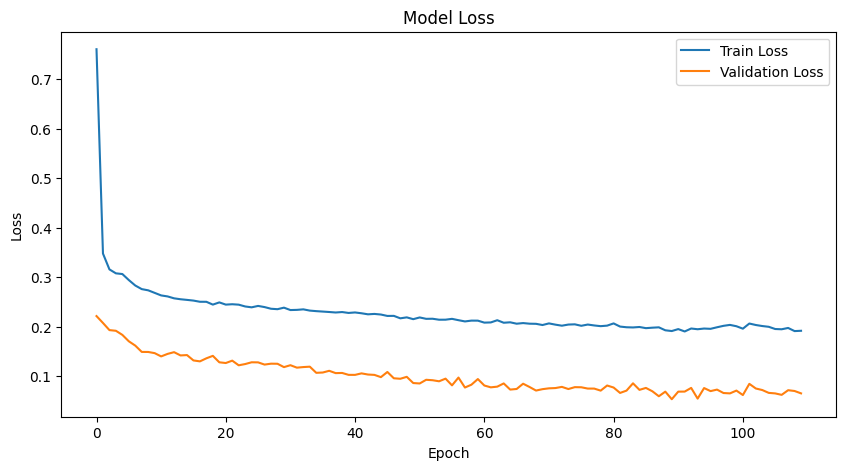

In [14]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.savefig('figures/dnn_training_validation_loss.png')
plt.show()

Now, we can evaluate the model on the test data.

In [15]:
# Evaluate on the test data
test_mse = dnn.evaluate(X_test_poly, y_test, verbose=0)

# Predictions
y_pred = dnn.predict(X_test_poly)


# Inverse transform the predictions and actual values to get them back to original scale
y_pred = scaler_y.inverse_transform(y_pred)
y_test = scaler_y.inverse_transform(y_test)

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step


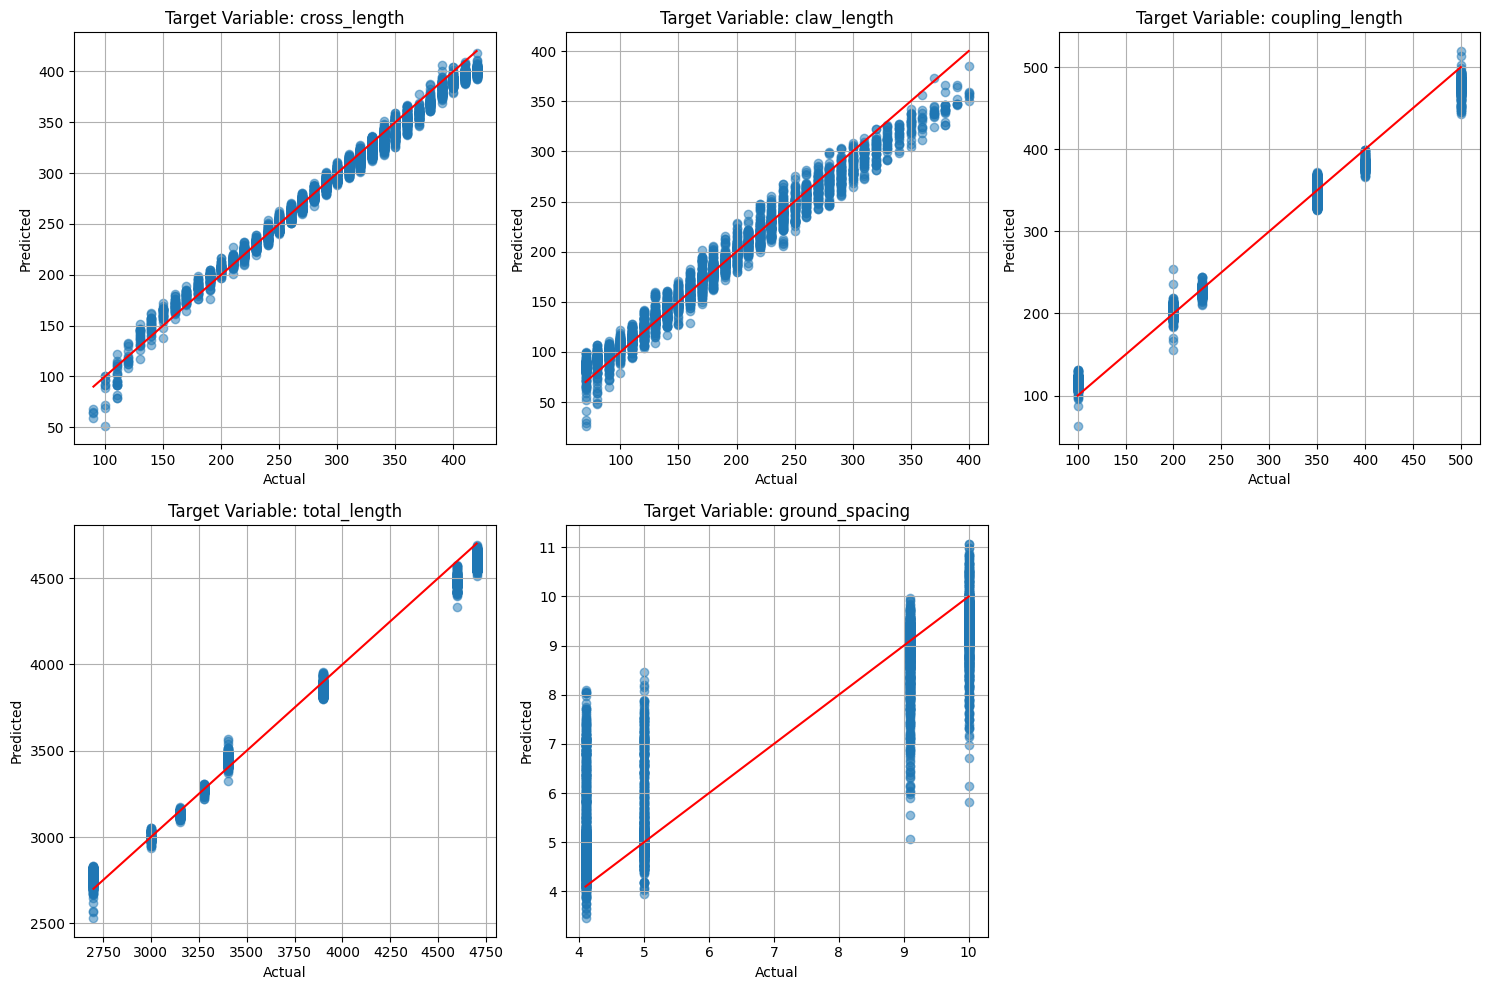

In [16]:
# Plot predicted vs actual values for each target variable
plt.figure(figsize=(15, 10))
for i in range(y_test.shape[1]):
    plt.subplot(2, 3, i + 1)
    plt.scatter(y_test[:, i], y_pred[:, i], alpha=0.5)
    plt.plot([min(y_test[:, i]), max(y_test[:, i])], [min(y_test[:, i]), max(y_test[:, i])], 'r')
    plt.title(f'Target Variable: {design_parameters[i]}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(True)
plt.tight_layout()
plt.savefig('figures/dnn_predicted_vs_actual.png')
plt.show()

Cool to see that such a basic model can generally capture the trends in the data (sort of haha). Of course, we can always improve the model by tuning the hyperparameters, adding more data, or using more sophisticated models.

Let's see how the model performs on some different data points so that we can compare it to the scaling interpolation algorithm and the closest simulation results. First, lets load the test dataframes.

In [17]:
test_data = pd.read_csv(f"data/test_data.csv")
test_data

qubit_frequency_GHz  cavity_frequency_GHz  anharmonicity_MHz   kappa_kHz  \
0             4.621651              6.920735        -194.264031  163.433945   
1             5.514262              6.468747        -288.056418  127.175543   
2             5.039644              6.965297        -235.346921   35.666245   
3             4.241134              5.806681        -160.933514  153.074402   
4             4.879756              5.889439        -219.068857   97.823504   
5             5.448084              5.762119        -280.304835  211.778480   

        g_MHz  
0  102.199270  
1   67.947060  
2   73.162768  
3   90.698935  
4   84.702197  
5   69.241372

Using the trained model to predict the design space variables for the test data.

In [18]:
# Extract input features
X_test = test_data[hamiltonian_parameters].values

# Transform input features
X_test_poly = poly.transform(X_test)
X_test_poly = scaler_X.transform(X_test_poly)

# Make predictions with the DNN model
y_pred_dnn = scaler_y.inverse_transform(dnn.predict(X_test_poly))

# save the predictions for future use
np.savetxt("data/y_pred_dnn.csv", y_pred_dnn, delimiter=",")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Loading the corresponding scaling interpolation and closest simulation data points for comparison.

In [19]:
interp_df = pd.read_csv("data/scaling_interp_data.csv", index_col=0)
interp_df.columns = ['total_length', 'coupling_length', 'cross_length', 'claw_length', 'Ej', 'ground_spacing']

# Sort to match the order of target_names
scaling_interp_pred = interp_df[design_parameters].values

In [20]:
closest_df = pd.read_csv("data/closest_sim_data.csv", index_col=0)
closest_df.columns = ['total_length', 'coupling_length', 'cross_length', 'claw_length', 'ground_spacing', 'Ej']

# Sort to match the order of target_names
closest_results = closest_df[design_parameters].values

Moments of truth! Let's see how the model performs compared to the scaling (physics) interpolation and closest simulation results.

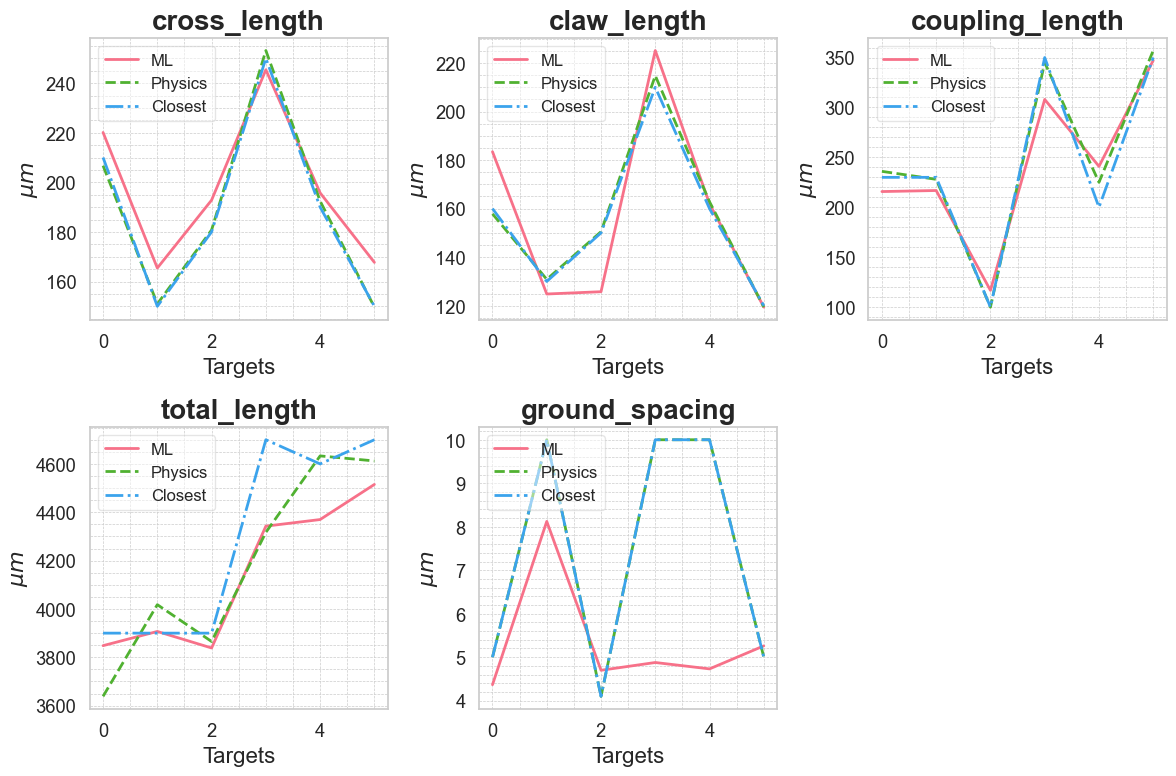

In [21]:
sns.set(style="whitegrid", font_scale=1.2)
colors = sns.color_palette("husl", 3)  # Get a palette with 3 different hues

# Plot comparisons of predicted values
plt.figure(figsize=(12, 8))


for i, target_name in enumerate(design_parameters):
    plt.subplot(2, 3, i + 1)
    plt.plot(y_pred_dnn[:, i], label='ML', color=colors[0], linewidth=2)
    plt.plot(scaling_interp_pred[:, i], label='Physics', color=colors[1], linewidth=2, linestyle='--')
    plt.plot(closest_results[:, i], label='Closest', color=colors[2], linewidth=2, linestyle='-.')
    plt.ylabel(r'$\mu m$', fontsize=16)
    # Adding title and customizing fonts
    plt.title(f'{target_name}', fontsize=20, weight='bold')
    plt.xlabel('Targets', fontsize=16)

    # Improve legends
    plt.legend(loc='upper left', fontsize=12, fancybox=True, framealpha=0.5)

    # Adding grid and minor ticks for better readability
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.minorticks_on()

plt.tight_layout()
plt.savefig('figures/comparison_predicted_values.png')
plt.show()


## Simulate and Benchmark the ML Model

To truly evaluate the model's performance, we need to simulate the qubit-cavity system using the predicted design space variables and compute the corresponding Hamiltonian parameters and see how they compare to the target Hamiltonian parameters.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from squadds import SQuADDS_DB, Analyzer

In [3]:
%matplotlib inline

In [4]:
db = SQuADDS_DB()
db.select_system(["qubit","cavity_claw"])
db.select_qubit("TransmonCross")
db.select_cavity_claw("RouteMeander")
db.select_resonator_type("quarter")
merged_df = db.create_system_df()
analyzer = Analyzer(db)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
y_pred_dnn = np.loadtxt("data/y_pred_dnn.csv", delimiter=",")

In [6]:
test_data = pd.read_csv(f"data/test_data.csv")

Using the following method to extract the `designs_df` that we will use to simulate the qubit-cavity system.

In [7]:
from squadds.interpolations.utils import get_design_from_ml_predictions

designs_df = get_design_from_ml_predictions(analyzer, test_data, y_pred_dnn)
designs_df

Time taken to add the coupled H params: 3.9641311168670654 seconds


coupler_type                               design_options_qubit  \
0          CLT  {'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...   
1          CLT  {'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...   
2          CLT  {'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...   
3          CLT  {'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...   
4          CLT  {'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...   
5          CLT  {'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...   

                          design_options_cavity_claw  \
0  {'claw_opts': {'connection_pads': {'readout': ...   
1  {'claw_opts': {'connection_pads': {'readout': ...   
2  {'claw_opts': {'connection_pads': {'readout': ...   
3  {'claw_opts': {'connection_pads': {'readout': ...   
4  {'claw_opts': {'connection_pads': {'readout': ...   
5  {'claw_opts': {'connection_pads': {'readout': ...   

                                         setup_qubit  \
0  {'auto_increase_solution_order': True, 'enable...   
1  {'auto_increase_solution_order': True, 'enable...   
2  {'auto_increase_solution_order': True, 'enable...   
3  {'auto_increase_solution_order': True, 'enable...   
4  {'auto_increase_solution_order': True, 'enable...   
5  {'auto_increase_solution_order': True, 'enable...   

                                   setup_cavity_claw  \
0  {'basis_order': 1, 'max_delta_f': 0.05, 'max_p...   
1  {'basis_order': 1, 'max_delta_f': 0.05, 'max_p...   
2  {'basis_order': 1, 'max_delta_f': 0.05, 'max_p...   
3  {'basis_order': 1, 'max_delta_f': 0.05, 'max_p...   
4  {'basis_order': 1, 'max_delta_f': 0.05, 'max_p...   
5  {'basis_order': 1, 'max_delta_f': 0.05, 'max_p...   

                                      design_options  
0  {'cavity_claw_options': {'coupler_type': 'CLT'...  
1  {'cavity_claw_options': {'coupler_type': 'CLT'...  
2  {'cavity_claw_options': {'coupler_type': 'CLT'...  
3  {'cavity_claw_options': {'coupler_type': 'CLT'...  
4  {'cavity_claw_options': {'coupler_type': 'CLT'...  
5  {'cavity_claw_options': {'coupler_type': 'CLT'...

### Ansys Simulation

Now to simulate each design in the `designs_df` in Ansys and extract the Hamiltonian parameters.

In [ ]:
from squadds import AnsysSimulator

In [ ]:
H_params_simmed = []

for index, row in designs_df.iterrows():
    print(f"Simulating design {index}")
    df = designs_df.iloc[index]
    ansys_simulator = AnsysSimulator(analyzer, df)
    ansys_results = ansys_simulator.simulate(df)
    hamiltonian_results = ansys_results["sim_results"]
    H_params_simmed.append(hamiltonian_results)

For the model used in this example but with its hyperparameters optimized, I was able to get the following results

<div style="text-align: center;">
  <div style="display: inline-flex; justify-content: center; align-items: center; gap: 20px;">
    <div style="flex: 1; text-align: center;">
      <img src="ga.png" alt="Figure 1" style="width: 80%;">
    </div>
    <div style="flex: 1; text-align: center;">
      <img src="kc.png" alt="Figure 2" style="width: 80%;">
    </div>
  </div>
</div>


### `palace` Simulations

If you don't have access to Ansys, you can use the [palace](https://awslabs.github.io/palace/) simulator to simulate the qubit-cavity system. We cover how to use `palace` in [Tutorial 7](https://lfl-lab.github.io/SQuADDS/source/tutorials/Tutorial-7_Simulate_designs_with_palace.html).

We are actively working on developing robust, accurate, and stable simulations using the `palace` backend in collaboration with our friends at the [SQDLab](https://www.sqdlab.org/). 

In the meantime, we encourage you to explore `palace` on your own with the following resources:

- **[Palace Documentation](https://awslabs.github.io/palace/):** Official documentation for the `palace` simulator.
- **[Palace Installation Guide](https://lfl-lab.github.io/SQuADDS/source/resources/palace.html):** Step-by-step instructions on how to install `palace` on all platforms.
- **[Palace Simulation with Qiskit Metal](https://github.com/sqdlab/SQDMetal):** A simulation framework for using `palace` from `qiskit-metal`.
- **[SQDMetal Example workflow with Palace](https://github.com/sqdlab/SQDMetal/blob/main/docs/User/WorkedExamples/README.md):** A worked example of using `palace` with `qiskit-metal` to run eigenmode and capacitance simulations.

These resources should help you get started with `palace` and enable you to perform simulations effectively until our enhanced integration is ready. Consider contributing to [SQDMetal](https://github.com/sqdlab/SQDMetal) and [SQuADDS](https://github.com/lfl-lab/SQuADDS) to help us improve the `palace` integration!

### COMSOL Simulation

You can also use `SQDMetal` to run the simulations in COMSOL as well. Read more about it [here](https://github.com/sqdlab/SQDMetal/blob/main/docs/User/Sim_Comsol.md)

## Deploy the ML Model to HuggingFace

Once you have developed a model that you are happy with and ideally performs really well, you can deploy it to HuggingFace for others to use.

HuggingFace makes it ridiculously easy to deploy an ML model. All you need to do is:

1. Load the model.
2. Save the model in the format required by HuggingFace.

```python
model.save(f"hf://{hf_username}/{model_name}")
```

In [ ]:
from tensorflow.keras.models import load_model

model_dnn = load_model("models/simple_dnn.keras")
model_dnn.save("hf://shanto268/qiskit-fall-fest-2024-test-model")

If your model is **REALLYYYYY good**, then send me an [email](mailto:shanto@usc.edu) with the link to your model and I will add it to the SQuADDS ML model collection.

## Next Steps...

Please contribute to [SQuADDS!](https://lfl-lab.github.io/SQuADDS/source/resources/contribute.html)

## License

<div style='width: 100%; background-color:#3cb1c2;color:#324344;padding-left: 10px; padding-bottom: 10px; padding-right: 10px; padding-top: 5px'>
    <h3>This code is a part of SQuADDS</h3>
    <p>Developed by Sadman Ahmed Shanto</p>
    <p>This tutorial is written by Sadman Ahmed Shanto</p> 
    <p>&copy; Copyright Sadman Ahmed Shanto & Eli Levenson-Falk 2025.</p>
    <p>This code is licensed under the MIT License. You may<br> obtain a copy of this license in the LICENSE.txt file in the root directory<br> of this source tree.</p>
    <p>Any modifications or derivative works of this code must retain this<br>copyright notice, and modified files need to carry a notice indicating<br>that they have been altered from the originals.</p>
</div>